In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import model
import utils
from utils.data import TRAIN_SEQUENCE_LENGTH, TEST_SEQUENCE_LENGTH, N_SEQUENCES_N6
import matplotlib as mpl
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch.nn as nn
from utils.data import TEST_INDICIES
import torch.nn.functional as F

BATCH_SIZE = 64
LATENT_DIM = 64

mpl.rcParams["figure.dpi"] = 300

device = torch.device("mps")


In [5]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((2.2861415e-18,), (6.014277e-18,)),
    ]
)
data = utils.data.Datasets(
    "/Users/henrywilliams/Documents/uni/amml/assessment/data",
    transform,
    normalise=False,
)

train = data.n6_train().numpy()
train_set, test_set = train_test_split(train, test_size=0.2)

train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, BATCH_SIZE, shuffle=True)

full = data.n6_full(image_shape=(1, 36, 36))
train_full, test_full = train_test_split(full.numpy(), test_size=0.2)

train_loader_full = DataLoader(train_full, BATCH_SIZE)
test_loader_full = DataLoader(test_full, BATCH_SIZE)

AssertionError: Output of transformation should match image shape

In [81]:
def test(model, data):
    model.eval()
    test_loss = []

    for img in data:
        img = img.to(device)
        with torch.no_grad():
            recon, mu, logvar = model(img)
        loss = model.loss_fn(recon, img, mu, logvar, kld_weight=KLD_WEIGHT)
        test_loss.append(loss.cpu().detach().item())
    model.train()
    return np.mean(test_loss)


vae = model.VAE(LATENT_DIM).to(device)
train_losses = []
test_losses = []

EPOCHS = 200
INITIAL_LR = 0.01
KLD_WEIGHT = 0.005

optim = torch.optim.AdamW(vae.parameters(), lr=INITIAL_LR)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, "min", threshold=100)

for i in range(EPOCHS):
    torch.mps.empty_cache()
    for img in tqdm(
        train_loader,
        desc=f"Epoch {i + 1:02}/{EPOCHS}",
        postfix=f"Test Loss: {test_losses[-1]}" if i != 0 else "",
        leave=False,
    ):
        img = img.to(device)

        optim.zero_grad()

        reconstructed_image, mu, log_var = vae(img)
        loss = vae.loss_fn(reconstructed_image, img, mu, log_var, kld_weight=KLD_WEIGHT)
        loss.backward()
        train_losses.append(loss.cpu().detach().item())
        optim.step()
    test_loss = test(vae, test_loader)
    test_losses.append(test_loss)


KeyboardInterrupt: 

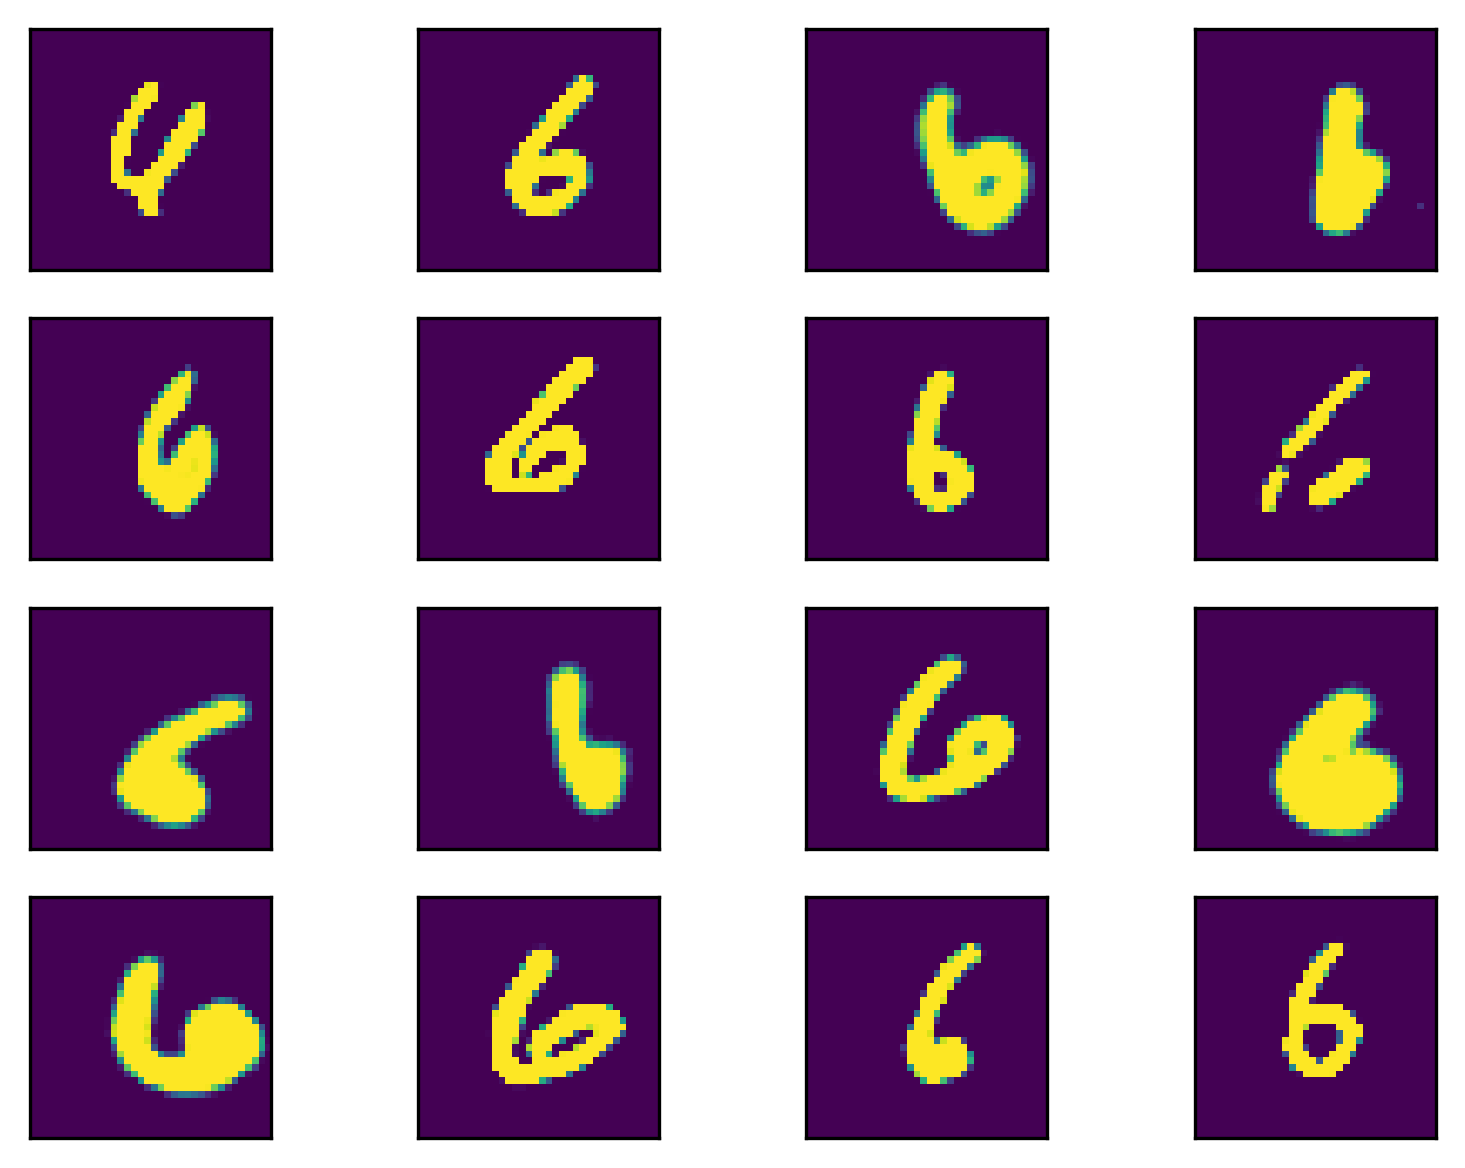

In [4]:
vae.eval()

img_ids = np.random.choice(len(test_set), 16)

fig, axs = plt.subplots(4, 4)

axs = axs.flatten()

for ax, id in zip(axs, img_ids):
    img = test_set[id]
    recons, _, _ = vae(torch.tensor(img).to(device).unsqueeze(0))
    ax.imshow(recons.cpu().detach().reshape(36, 36, 1))
    ax.set_xticks([])
    ax.set_yticks([])

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

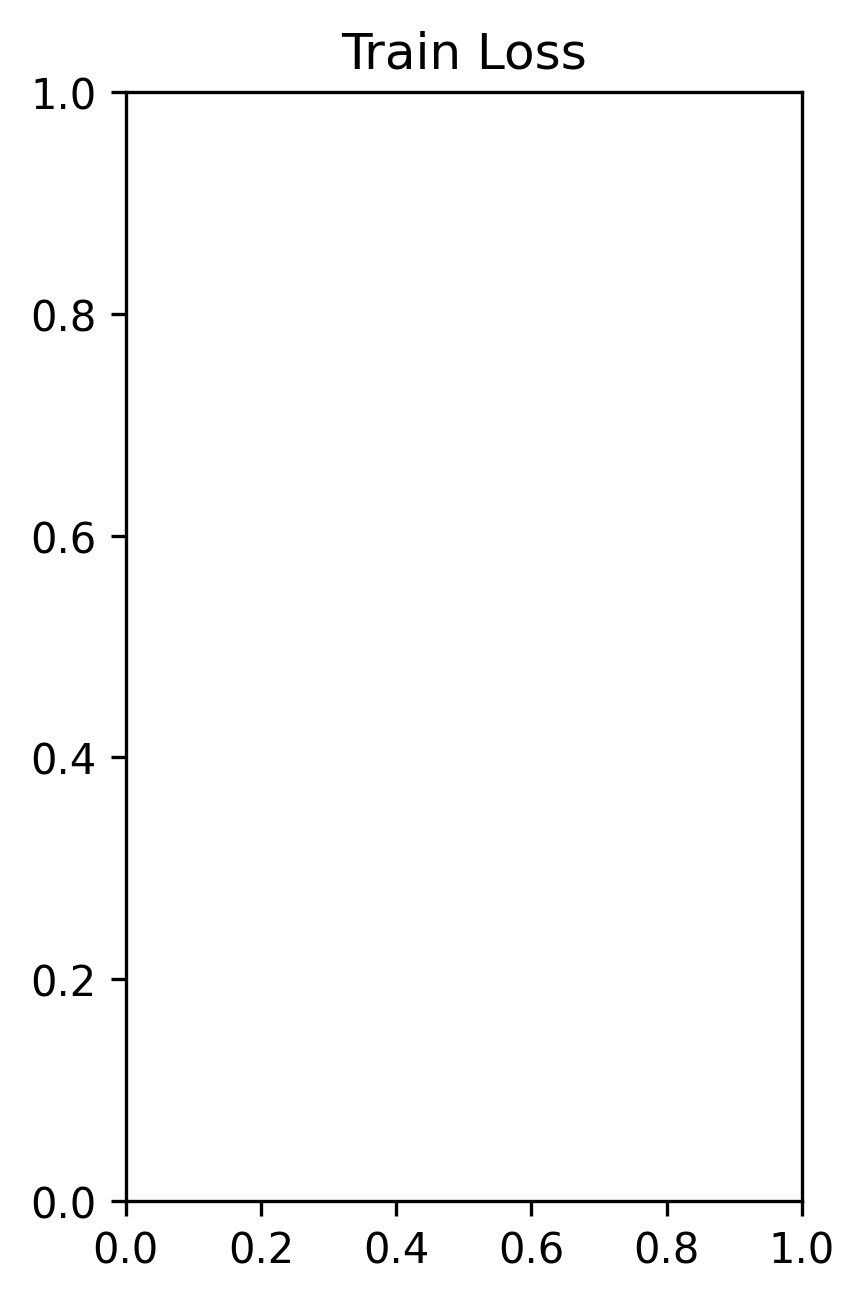

In [79]:
plt.subplot(1, 2, 1)
plt.title("Train Loss")
plt.plot(np.log(train_losses), label="ELBO")
# plt.plot(train_loss_df["recons_loss"], label="MSE")
# plt.plot(train_loss_df["kld_loss"], label="KL Divergence")
plt.subplot(1, 2, 2)
plt.title("Test Loss")
plt.plot(test_losses, label="ELBO")
# plt.plot(test_loss_df["recons_loss"], label="MSE")
# plt.plot(test_loss_df["kld_loss"], label="KL Divergence")
plt.legend()
plt.show()

In [7]:
class LSTM(nn.Module):
    def __init__(
        self,
        device,
        embedding_dim: int = 512,
        hidden_size: int = 1024,
        num_layers: int = 2,
    ):
        super(LSTM, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(
            in_features=self.hidden_size, out_features=self.embedding_dim
        )

    def get_embedding(self, x):
        return self.image_embedding(x)

    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
        return (h0, c0)

    def forward(self, x, sequence_length):
        x_hat = torch.zeros(x.shape[0], sequence_length, self.embedding_dim).to(
            self.device
        )
        x_hat[:, 0] = x[:, 0]
        state = self.init_hidden(x.shape[0])

        for i in range(1, sequence_length):
            z, state = self.lstm(x, state)
            x = self.fc(z)
            x_hat[:, i, :] = x[:, 0]

        return x_hat

In [77]:
BATCH_SIZE = 16

train = data.n6_train().numpy()
train, test = train_test_split(train, test_size=0.2)
train_loader = DataLoader(train, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test, shuffle=True, batch_size=BATCH_SIZE)

In [78]:
def test(model, data):
    model.eval()

    test_losses = []

    for d in data:
        bs = d.shape[0]
        hi = torch.zeros(N_LAYERS, bs, HIDDEN_SIZE).to(device)
        ci = torch.zeros(N_LAYERS, bs, HIDDEN_SIZE).to(device)
        sequence = d.to(torch.float32).to(device)

        sequence = np.array(
            [
                vae.reparameterize(*vae.encode(sequence[:, i])).cpu().detach()
                for i in range(14)
            ]
        )
        sequence = (
            torch.tensor(sequence)
            .reshape(bs, TRAIN_SEQUENCE_LENGTH, LATENT_DIM)
            .to(device)
        )

        with torch.no_grad():
            predicted = rnn(sequence[:, 0].unsqueeze(1), 14)

        loss = F.mse_loss(predicted, sequence)
        test_losses.append(loss.cpu().detach().item())

    model.train()
    return np.mean(test_losses)


HIDDEN_SIZE = 64
N_LAYERS = 3

rnn = LSTM(
    device, embedding_dim=LATENT_DIM, hidden_size=HIDDEN_SIZE, num_layers=N_LAYERS
).to(device)
optim = torch.optim.Adam(rnn.parameters())
train_losses = []
test_losses = []


for epoch in range(EPOCHS):
    test_losses.append(test(rnn, test_loader))
    loop = tqdm(
        train_loader,
        desc=f"Epoch {epoch + 1}/{EPOCHS}",
        leave=False,
        postfix=f"Test loss: {test_losses[-1]}",
    )
    torch.mps.empty_cache()
    for sequence in loop:
        bs = sequence.shape[0]
        sequence = sequence.to(torch.float32).to(device)

        sequence = np.array(
            [
                vae.reparameterize(*vae.encode(sequence[:, i])).cpu().detach()
                for i in range(14)
            ]
        )
        sequence = (
            torch.tensor(sequence)
            .reshape(bs, TRAIN_SEQUENCE_LENGTH, LATENT_DIM)
            .to(device)
        )

        predicted = rnn(sequence[:, 0].unsqueeze(1), 14)

        loss = F.mse_loss(predicted, sequence)

        optim.zero_grad()
        loss.backward()
        optim.step()
        train_losses.append(loss)

KeyboardInterrupt: 

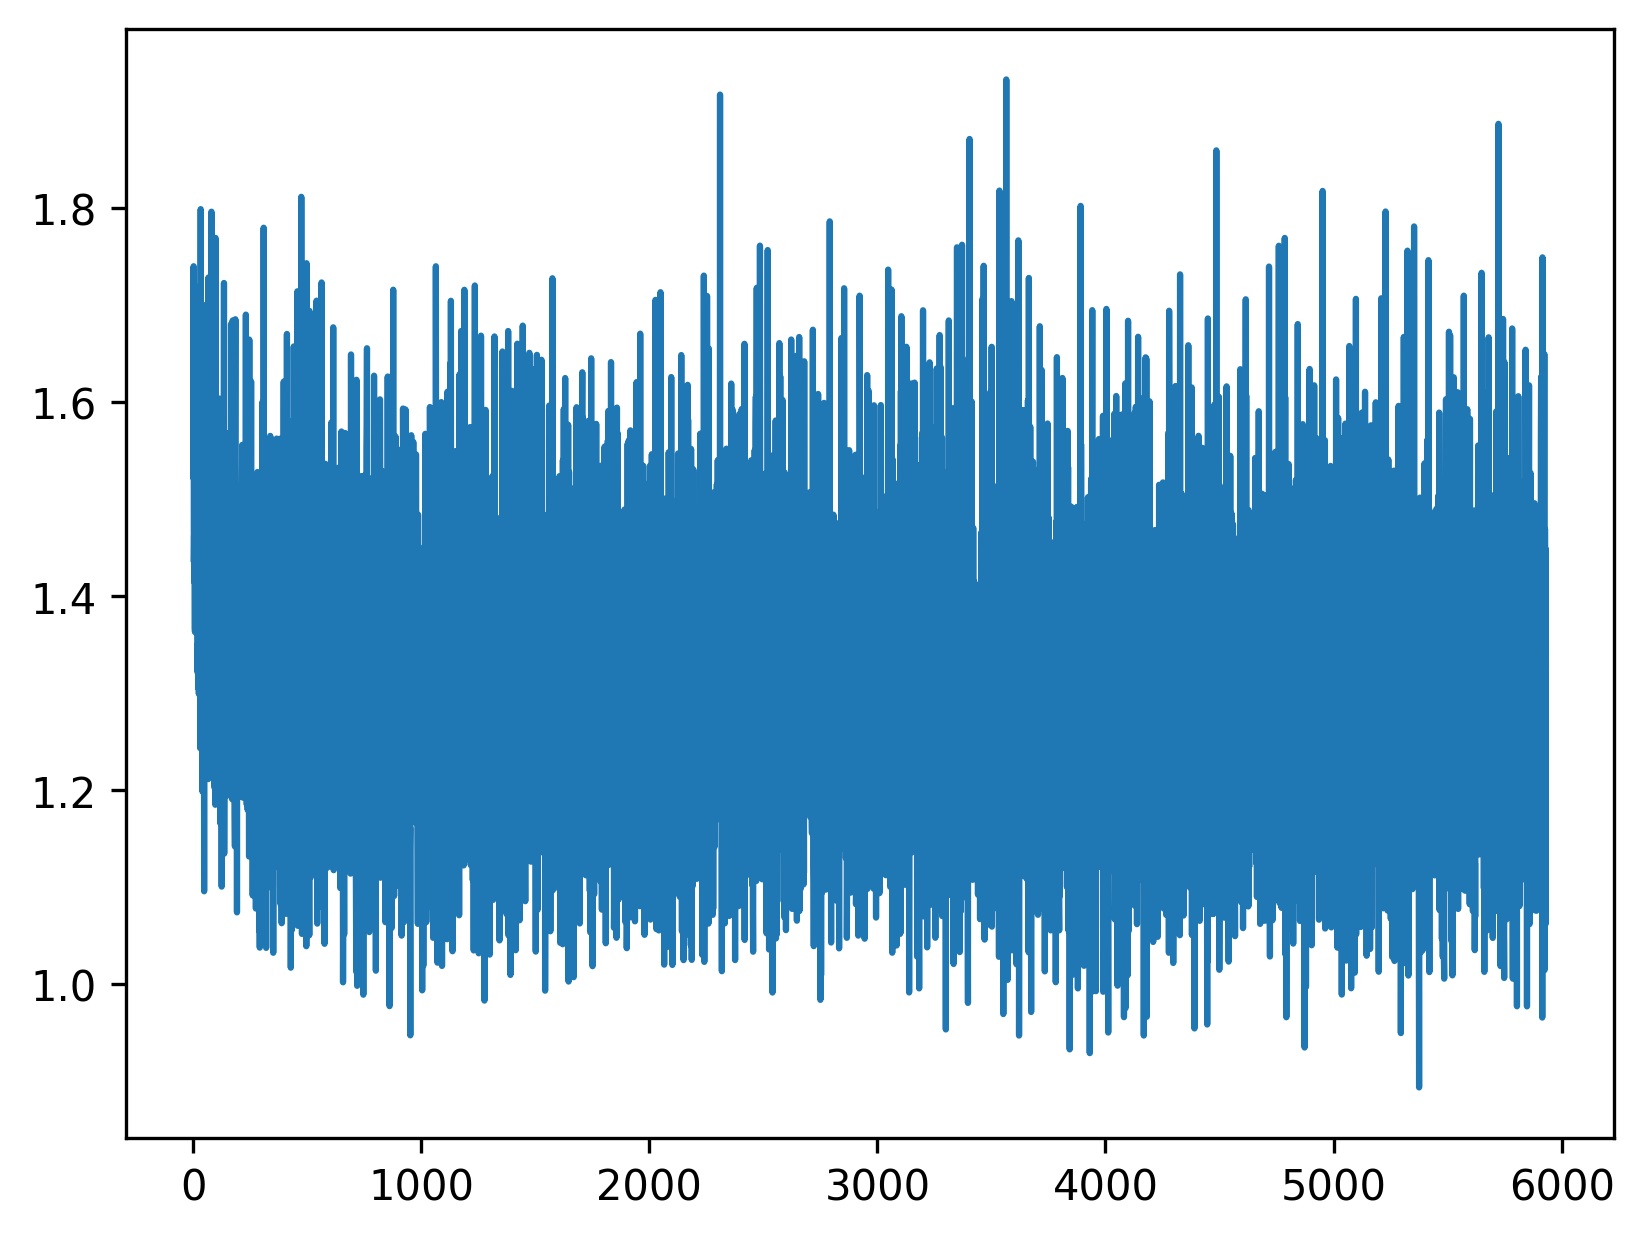

In [76]:
plt.plot([loss.cpu().detach().item() for loss in train_losses])

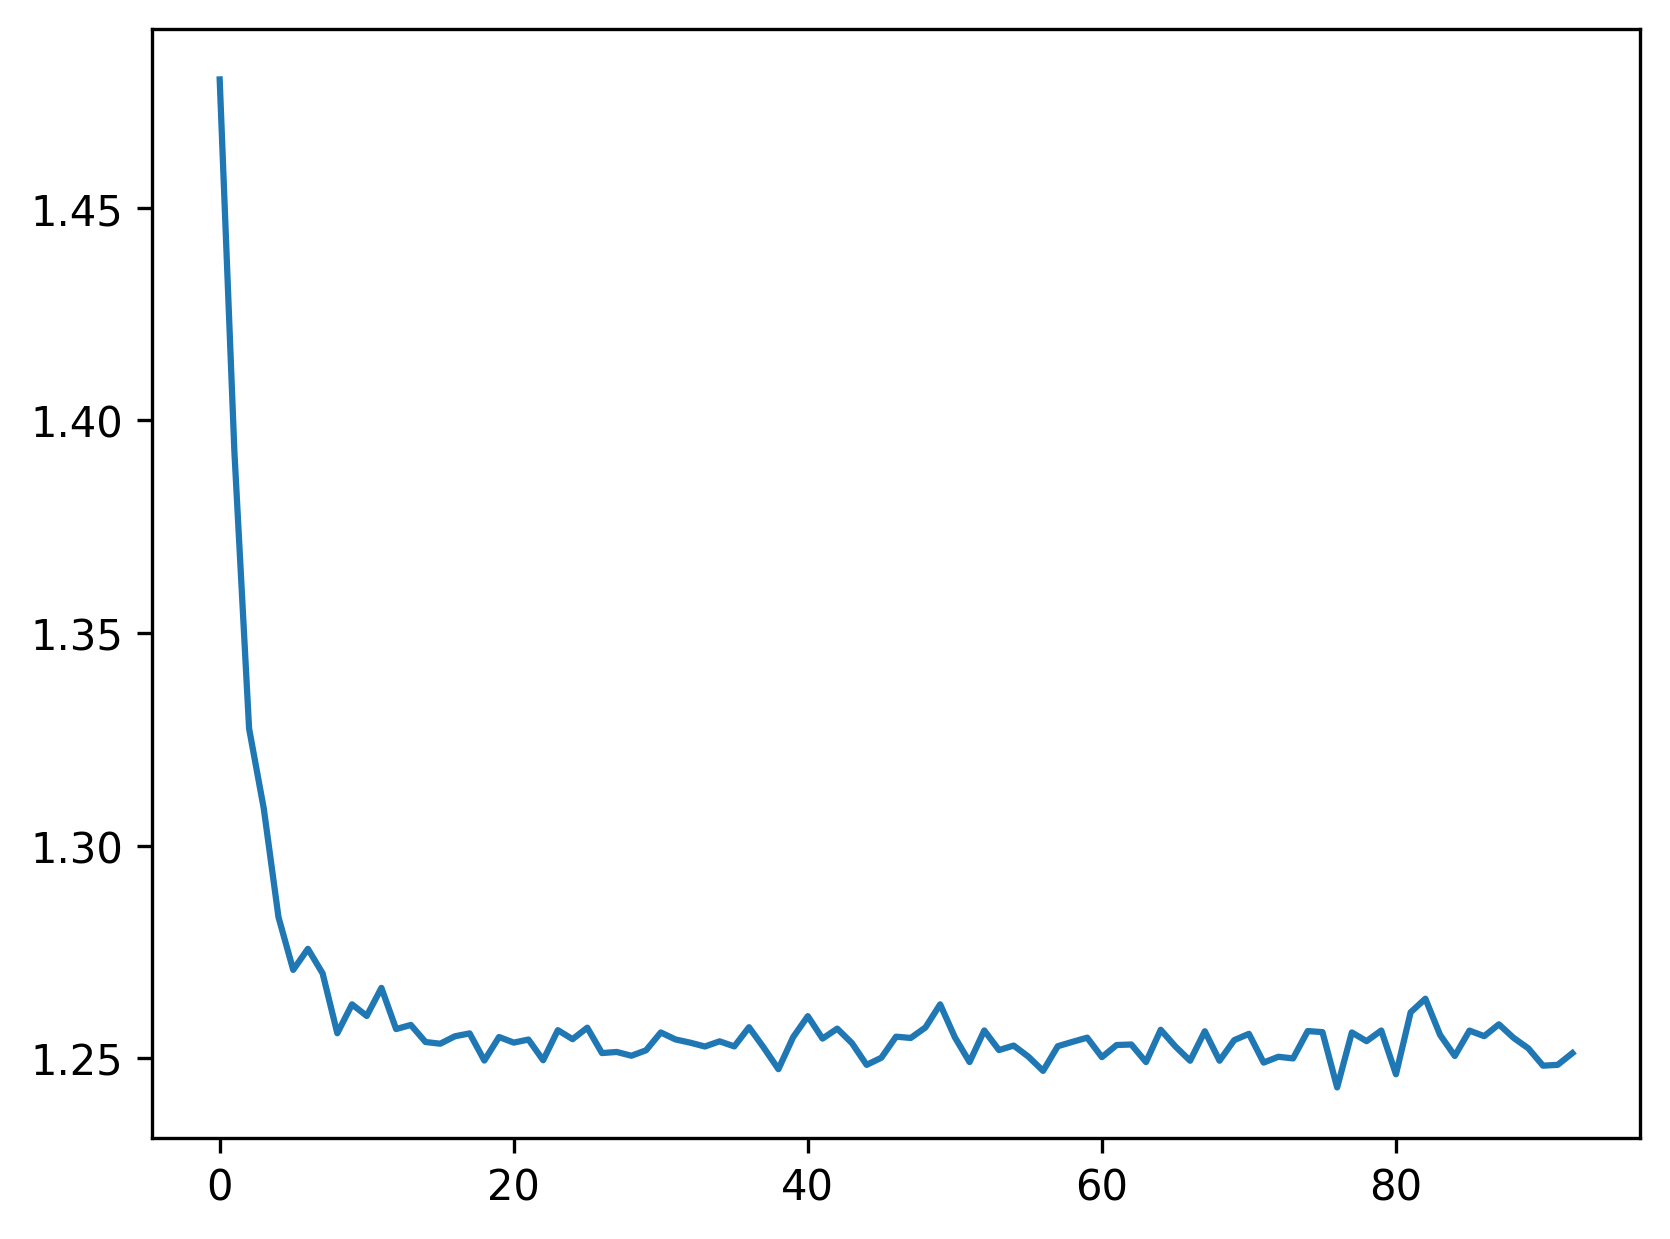

In [ ]:
plt.plot(test_losses)

In [93]:
rnn.eval()
vae.eval()

rnn.to(device)
vae.to(device)


idx = np.random.choice(len(test_full))
test_seq = torch.tensor(test_full[idx]).to(torch.float32).to(device)
X = test_seq[0].unsqueeze(0).unsqueeze(0)
print(X.shape)
predicted_encodings = rnn(X, 16)

for i in range(16):
    plt.subplot(2, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow()

torch.Size([1, 1, 1, 36, 36])

RuntimeError: The expanded size of the tensor (64) must match the existing size (36) at non-singleton dimension 1.  Target sizes: [1, 64].  Tensor sizes: [36, 36]